In [1]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import os
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_path = '../../sindy_models/original/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [3]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1


In [5]:
a1 = 1
a2 = test_data['sindy_coefficients'][2,0]/test_set_results['sindy_coefficients'][2,0]
a3 = np.sqrt(-test_set_results['sindy_coefficients'][5,2]/test_set_results['sindy_coefficients'][6,1]*a2**2)
b3 = -test_set_results['sindy_coefficients'][0,2]/test_set_results['sindy_coefficients'][3,2]

sindy_coefficients_transformed = np.zeros(test_set_results['sindy_coefficients'].shape)
sindy_coefficients_transformed[1,0] = test_set_results['sindy_coefficients'][1,0]
sindy_coefficients_transformed[2,0] = test_set_results['sindy_coefficients'][2,0]*a2/a1
sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = test_set_results['sindy_coefficients'][2,1]
sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = test_set_results['sindy_coefficients'][3,2]
sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3

z0_transformed = np.array([test_set_results['z'][0,0]/a1,
                           test_set_results['z'][0,1]/a2,
                           (test_set_results['z'][0,2] - b3)/a3])

In [6]:
lorenz_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
z_sim = sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])
z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                   params['poly_order'], params['include_sine'])

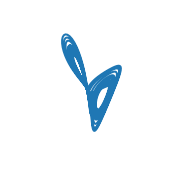

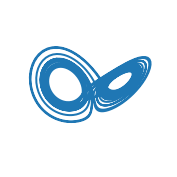

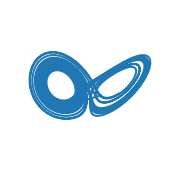

In [7]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

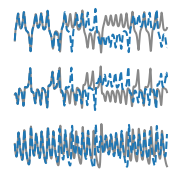

In [8]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, test_set_results['z'][:,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

In [9]:
Xi_plot = (params['coefficient_mask']*test_set_results['sindy_coefficients'])
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

## Test set analysis - in distribution

In [10]:
with open('../../test_data_max_variance.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1


In [12]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.var(test_data['x'])
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.var(test_data['dx'])
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.var(test_set_results['dz'])

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000027
Decoder relative SINDy error: 0.000180
SINDy reltive error, z: 0.000951


In [13]:
# Reference (4.1)
# Decoder relative error: 3e-5
# Decoder relative SINDy error: 2e-4
# SINDy reltive error, z: 7e-4


# Original Notebook
# Decoder relative error: 0.000027
# Decoder relative SINDy error: 0.000473
# SINDy reltive error, z: 0.000666


# Verified
# Decoder relative error: 0.000026
# Decoder relative SINDy error: 0.000151
# SINDy reltive error, z: 0.000541

# Decoder relative error: 0.000027
# Decoder relative SINDy error: 0.000114
# SINDy reltive error, z: 0.000303

# Decoder relative error: 0.000028
# Decoder relative SINDy error: 0.000159
# SINDy reltive error, z: 0.000656

# Decoder relative error: 0.000028
# Decoder relative SINDy error: 0.000261
# SINDy reltive error, z: 0.000736

# Decoder relative error: 0.000026
# Decoder relative SINDy error: 0.000118
# SINDy reltive error, z: 0.000550

# Verified MEAN +- STD
# Decoder relative error: 2.70e-05, 0.09e-05
# Decoder relative SINDy error: 1.6e-4, .5e-04
# SINDy reltive error, z: 5.6e-4, 1.4e-4

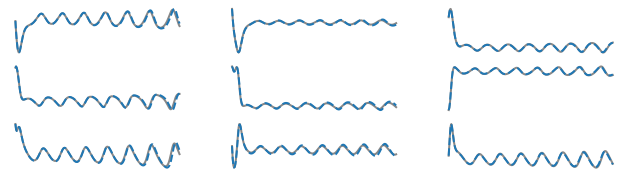

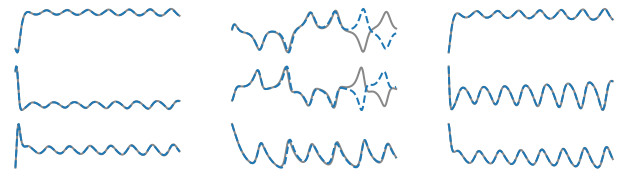

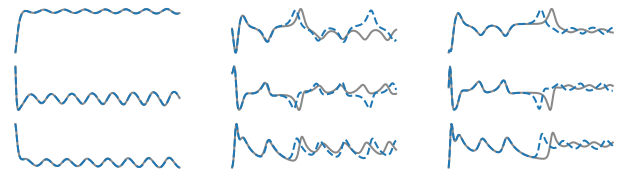

In [14]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

## Test set analysis - out of distribution

In [15]:
inDist_ic_widths = np.array([36,48,41])
outDist_extra_width = np.array([18,24,20])
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-6

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1


In [17]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.var(test_data['x'])
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.var(test_data['dx'])
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.var(test_set_results['dz'])

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.008615
Decoder relative SINDy error: 0.061420
SINDy reltive error, z: 0.064495


In [18]:
# Reference (4.1) ?
# Decoder relative error: 3e-5
# Decoder relative SINDy error: 2e-4
# SINDy reltive error, z: 7e-4

# Original Notebook
# Decoder relative error: 0.012790
# Decoder relative SINDy error: 0.106191
# SINDy reltive error, z: 0.079165


# Verified
# Decoder relative error: 0.011027
# Decoder relative SINDy error: 0.079695
# SINDy reltive error, z: 0.081881

# Decoder relative error: 0.008858
# Decoder relative SINDy error: 0.082416
# SINDy reltive error, z: 0.077889

# Decoder relative error: 0.020106
# Decoder relative SINDy error: 0.163238
# SINDy reltive error, z: 0.094049

# Decoder relative error: 0.021361
# Decoder relative SINDy error: 0.166206
# SINDy reltive error, z: 0.107538

# Decoder relative error: 0.011579
# Decoder relative SINDy error: 0.083661
# SINDy reltive error, z: 0.085549

# Verified MEAN +- STD
# Decoder relative error: 1.5e-2, 0.5e-2
# Decoder relative SINDy error: 12e-2, 4e-2)
# SINDy reltive error, z: (8.9e-2, 1.1e-2)

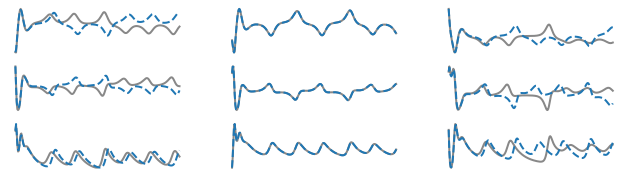

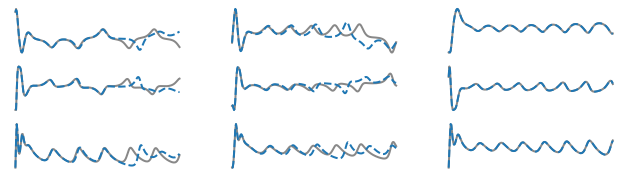

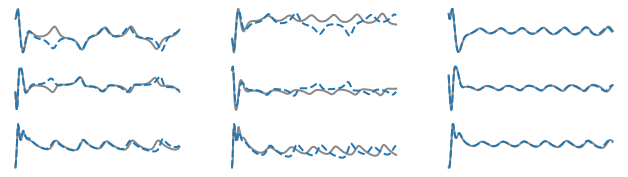

In [19]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

# Coefficients

In [20]:
import pandas as pd

In [21]:
def sindy_library_text(z, latent_dim, poly_order, include_sine=False):
    library = ['1']

    for i in range(latent_dim):
        library.append(z[i])

    if poly_order > 1:
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                library.append(f'{z[i]}*{z[j]}')

    if poly_order > 2:
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    library.append(f'{z[i]}*{z[j]}*{z[k]}')

    if poly_order > 3:
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    for p in range(k,latent_dim):
                        library.append(f'{z[i]}*{z[j]}*{z[k]}*{z[p]}')

    if poly_order > 4:
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    for p in range(k,latent_dim):
                        for q in range(p,latent_dim):
                            library.append(f'{z[i]}*{z[j]}*{z[k]}*{z[p]}*{z[q]}')

    if include_sine:
        for i in range(latent_dim):
            library.append(f'sin({z[i]})')

    return library

In [22]:
coefficient_names = sindy_library_text(['z_1', 'z_2', 'z_3'], 3, 3, include_sine=False)
coefficient_names, len(coefficient_names)

(['1',
  'z_1',
  'z_2',
  'z_3',
  'z_1*z_1',
  'z_1*z_2',
  'z_1*z_3',
  'z_2*z_2',
  'z_2*z_3',
  'z_3*z_3',
  'z_1*z_1*z_1',
  'z_1*z_1*z_2',
  'z_1*z_1*z_3',
  'z_1*z_2*z_2',
  'z_1*z_2*z_3',
  'z_1*z_3*z_3',
  'z_2*z_2*z_2',
  'z_2*z_2*z_3',
  'z_2*z_3*z_3',
  'z_3*z_3*z_3'],
 20)

In [23]:
coefficient_masks = []

In [24]:
tf.reset_default_graph()
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
coefficient_masks.append(params['coefficient_mask'])

In [25]:
len(coefficient_masks), coefficient_masks[0].shape

(1, (20, 3))

In [26]:
masked_coefficients_per_dim = [np.array([[(c[i].round(2) if m else '-') for c, m in zip(coefficients, mask[:, i])] for coefficients, mask in zip([test_set_results['sindy_coefficients']], coefficient_masks)]).reshape(1, 20) for i in range(3)]

In [27]:
for i in range(3): pd.DataFrame(masked_coefficients_per_dim[i], columns=coefficient_names).to_csv(f'./O_lorenz_coefficients_j{i}')

In [28]:
pd.DataFrame(masked_coefficients_per_dim[0], columns=coefficient_names)

1     z_1    z_2 z_3 z_1*z_1 z_1*z_2 z_1*z_3 z_2*z_2 z_2*z_3 z_3*z_3  \
0  -  -10.04  -10.9   -       -       -       -       -       -       -   

  z_1*z_1*z_1 z_1*z_1*z_2 z_1*z_1*z_3 z_1*z_2*z_2 z_1*z_2*z_3 z_1*z_3*z_3  \
0           -           -           -           -           -           -   

  z_2*z_2*z_2 z_2*z_2*z_3 z_2*z_3*z_3 z_3*z_3*z_3  
0           -           -           -           -

In [29]:
pd.DataFrame(masked_coefficients_per_dim[1], columns=coefficient_names)

1 z_1    z_2 z_3 z_1*z_1 z_1*z_2 z_1*z_3 z_2*z_2 z_2*z_3 z_3*z_3  \
0  -   -  -0.94   -       -       -    9.55       -       -       -   

  z_1*z_1*z_1 z_1*z_1*z_2 z_1*z_1*z_3 z_1*z_2*z_2 z_1*z_2*z_3 z_1*z_3*z_3  \
0           -           -           -           -           -           -   

  z_2*z_2*z_2 z_2*z_2*z_3 z_2*z_3*z_3 z_3*z_3*z_3  
0           -           -           -           -

In [30]:
pd.DataFrame(masked_coefficients_per_dim[2], columns=coefficient_names)

1 z_1 z_2    z_3 z_1*z_1 z_1*z_2 z_1*z_3 z_2*z_2 z_2*z_3 z_3*z_3  \
0  -7.13   -   -  -2.68       -   -3.12       -       -       -       -   

  z_1*z_1*z_1 z_1*z_1*z_2 z_1*z_1*z_3 z_1*z_2*z_2 z_1*z_2*z_3 z_1*z_3*z_3  \
0           -           -           -           -           -           -   

  z_2*z_2*z_2 z_2*z_2*z_3 z_2*z_3*z_3 z_3*z_3*z_3  
0           -           -           -           -